<a href="https://colab.research.google.com/github/paudelsushil/adleosus/blob/main/assignment5_sus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5 - Fine-tuning and Inference

## Instructions

Please follow the [instructions](assignments-setup.qmd) for setting up, completing, and submitting your assignments.

<font color='red'>

**Important Note**:

- If you are using ChatGPT or any other AI based services to correct your writings or errors in code, you are required to provide a citation link.
- For answers to theoretical questions you should provide references for the source of your answers.

</font>

## Theoretical questions

### Q1.

Describe the basic structure of attention mechanisms and how--and where--they are used in CNNs designed for semantic segmentation. The more complete the answer, the better. By complete, we mean, what are some of the differences in attention mechanisms, what are some examples of their application, etc. (5 points)



### Answer to Q1
Basic Structure of attention mechanisms consists of three main components:

**A. Generating Attention Maps:**

  1. Query

    A vector representing the current state of the decoder.
    Usually the output of the previous decoder step.
  
  2. Keys and Values

    A set of vectors representing the encoded input sequence.
    Both keys and values have the same dimensionality.
  
  3. Attention Function
Attention mechanisms are often integrated into CNNs for semantic segmentation in various ways:

    a. Encoder-Decoder Architectures:
Attention can be applied in the decoder stage to refine the segmentation results by focusing on relevant features from the encoder.

    b. Spatial Attention Modules:
These modules can be inserted between convolutional layers to enhance feature representations by highlighting important spatial locations.

    c. Channel Attention Modules:
These modules can be used to learn the importance of different feature channels and recalibrate their contribution to the final segmentation.

    d. Self-Attention Mechanisms:
These mechanisms can be used to capture long-range dependencies within the feature maps, improving the understanding of global context.

**B. Weighting the Input**

The attention scores obtained from the similarity calculation are used to compute a weighted sum of the values, producing the final output of the attention mechanism

**C. Output Feature Maps:**

The weighted feature map is then fed into subsequent layers of the CNN, carrying the enhanced contextual information.


The application of attention mechanism in CNNs for semantic segmentation are:

1. Global Context Integration:

Attention mechanisms are often used to incorporate global context information into the encoder-decoder structure of CNNs, enabling the network to make more informed segmentation decisions based on a broader spatial context.

2. Feature Fusion:

By selectively attending to relevant features at different scales and locations, attention mechanisms facilitate effective feature fusion, allowing the network to combine multi-scale information for improved segmentation accuracy.

3. Efficient Multi-Source Fusion:

Co-attention mechanisms are employed with lateral skip connections to enhance the efficiency of multi-scale feature fusion in encoder-decoder architectures, enabling the network to leverage information from multiple sources effectively.

4. Joint Multi-Task Learning:

Advanced attention structures like gated convolution layers support joint learning of shape and semantics, enabling the network to simultaneously handle multiple tasks and capture complex relationships between different aspects of the input data.



We can integrate Attention Mechanism in CNN Arc
1. Positioning in the Network:

Attention mechanisms are strategically placed in CNN architectures, often at key positions such as the top layer of the decoder before the classifier or at the end of the encoder, to leverage global context and facilitate efficient feature fusion.

2. Multi-Branch Structures:

Attention modules are commonly implemented as multi-branch structures, with query, key, and value branches that enable the network to focus on different dimensions of the input data and levels of abstraction, enhancing the network's representational power.


Benefits:

Integrating an attention mechanism into a CNN can provide several benefits:

Improved accuracy and performance on various tasks.
Increased interpretability of the network's predictions.
Reduced computational cost by focusing on important regions and channels.

Examples of Attention Mechanism in CNNs are as follows:

- **SENet**: Uses spatial attention to improve image classification accuracy.
- **CBAM**: Uses channel attention to improve object detection and segmentation performance.
- **DANet**: Uses dual attention to capture both where and what information is important in medical image segmentation.
- **DRU with Attention**: Uses attention gating to generate more coherent and realistic images.

(Sam et al., 2023) and https://chat.openai.com/

### Q2.

An important characteristic of RNNs is their ability to handle sequential input of varying length. How do RNNs gain this ability? (5 points)

### Answer to Q2
RNNs possess the capability to process sequential data inputs of varying lengths due to their recursive structure and internal memory. The key mechanisms that enable RNNs to handle sequences of different lengths include:
1. Recursion: Sequential processing
- At each time step, the RNN takes the current input and the previous hidden state as input.
- The RNN then computes the output for the current time step and updates the hidden state based on the current input and the previous hidden state.

2. Hidden state: The memory keeper

- The hidden state is a crucial element in handling variable-length sequences. It acts as a summary of the information seen so far in the sequence.
- As the network processes each input, the hidden state is updated based on the current input and the previous hidden state.
- This continuous updating allows the hidden state to capture the essence of the sequence regardless of its length.


3. Truncated Backpropagation:
- During training, RNNs use truncated backpropagation through time (BPTT) to learn from sequences of varying lengths.
- BPTT unrolls the RNN for a fixed number of time steps and then calculates the gradients based on the error at the final time step.

(Sam et al., 2023) and https://chat.openai.com/



## Coding assignments

The coding work here focus on continuing and complete our model pipeline, including assignments focused on:

1. Adding the imagery onto which we are predicting into the pipeline;
2. Adding code for running predictions;
3. Fine-tuning the previously trained model

The code to undertake this is mostly provided in the sections that follow under Key Code, including a U-Net model (note: you can replace that with the one you developed in your previous assignments, if you prefer).

The specific assignments are below the Key Code section.

### Set-up

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
%%capture
!pip install rasterio

In [148]:
import os
import math
from pathlib import Path
from datetime import datetime, timedelta
import tqdm
import pandas as pd
import numpy as np
import cv2
import random
import rasterio

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.tensorboard import SummaryWriter
from IPython.core.debugger import set_trace
from IPython.display import Image

import matplotlib.pyplot as plt

### Key Code

#### Utility functions

In [5]:
def load_data(data_path, is_label=False, apply_normalization=False,
              dtype=np.float32, verbose=False):
    r"""
    Open data using gdal, read it as an array and normalize it.
    Arguments:
            data_path (string) -- Full path including filename of the data
                source we wish to load.
            is_label (binary) -- If True then the layer is a ground truth
                (category index) and if set to False the layer is a reflectance
                band.
            apply_normalization (binary) -- If true min/max normalization will b
                e applied on each band.
            dtype (np.dtype) -- Data type of the output image chips.
            verbose (binary) -- if set to true, print a screen statement on the
                loaded band.
    Returns:
            image -- Returns the loaded image as a 32-bit float numpy ndarray
                with shape (height, width, num_bands).
    """

    # Inform user of the file names being loaded from the Dataset.
    if verbose:
        print('loading file:{}'.format(data_path))

    # open dataset using rasterio library.
    with rasterio.open(data_path, "r") as src:

        if is_label:
            if src.count != 1:
                raise ValueError("Expected Label to have exactly one channel.")
            img = src.read(1)

        else:
            if apply_normalization:
                img = min_max_normalize_image(src.read())
                img = img.astype(dtype)
            else:
                img = src.read()
                img = img.astype(dtype)

    return img

#########################

def get_meta_from_bounds(image, overlap=None):
    with rasterio.open(image, "r") as src:
        meta = src.meta

    if overlap:
        dst_width = src.width - 2 * overlap
        dst_height = src.height - 2 * overlap
        window = window(overlap, overlap, dst_width, dst_height)
        win_transform = src.window_transform(window)
        meta.update({
            'width': dst_width,
            'height': dst_height,
            'transform': win_transform,
            'count': 1,
            'dtype': 'int8'
        })

    return meta

#########################

def load_params(params_dir, model, freeze_params=None):
    """Load a set of parameters into a PyTorch model.
    Args:
        params_dir (str): Path to the ".pth" or ".pt" file containing the input
            parameters.
        model (pytorch nn object): Initialized model.
        freeze_params (list[int] or None, optional): List of parameter indices
            to freeze (i.e., set to require no gradients). Default is None,
            which means that all parameters are trainable.

    Returns:
        None

    Raises:
        FileNotFoundError: If the specified file does not exist.

    Example:
        # Load parameters from file and freeze the first layer
        load_params("params.pth", freeze_params=[0])
    """
    # Load input parameters from file
    input_params = torch.load(params_dir)

    # Filter out parameters that are not in the model
    model_dict = model.state_dict()
    if "module" in list(input_params.keys())[0]:
        input_params_filter = {k[7:]: v.cpu() for k, v in input_params.items()
                               if k[7:] in model_dict}
    else:
        input_params_filter = {k: v.cpu() for k, v in input_params.items()
                               if k in model_dict}

    # Update the model parameters with the input parameters
    model_dict.update(input_params_filter)
    model.load_state_dict(model_dict)

    # free some layers
    if freeze_params is not None:
        for i, p in enumerate(model.parameters()):
            if i in freeze_params:
                p.requires_grad = False

    return model

#### Pre-processing functions

##### Input normalization

In [7]:
def min_max_normalize_image(image, dtype=np.float32):
    """
    image_path(str) : Absolute path to the image patch.
    dtype (numpy datatype) : data type of the normalized image default is
    "np.float32".
    """

    # Calculate the minimum and maximum values for each band
    min_values = np.nanmin(image, axis=(1, 2))[:, np.newaxis, np.newaxis]
    max_values = np.nanmax(image, axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Normalize the image data to the range [0, 1]
    normalized_img = (image - min_values) / (max_values - min_values)

    # Return the normalized image data
    return normalized_img

##### Image augmentation techniques

In [14]:
def flip_image_and_label(image, label, flip_type):
    """
    Applies horizontal or vertical flip augmentation to an image patch and label

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        flip_type (string) : Based on the direction of flip. Can be either
            'hflip' or 'vflip'.

    Returns:
        A tuple containing the flipped image patch and label as numpy arrays.
    """
    if flip_type == 'hflip':
        # Apply horizontal flip augmentation to the image patch
        flipped_image = cv2.flip(image, 1)

        # Apply horizontal flip augmentation to the label
        flipped_label = cv2.flip(label, 1)

    elif flip_type == 'vflip':
        # Apply vertical flip augmentation to the image patch
        flipped_image = cv2.flip(image, 0)

        # Apply vertical flip augmentation to the label
        flipped_label = cv2.flip(label, 0)

    else:
        raise ValueError("Flip direction must be 'horizontal' or 'vertical'.")

    # Return the flipped image patch and label as a tuple
    return flipped_image.copy(), flipped_label.copy()


def rotate_image_and_label(image, label, angle):
    """
    Applies rotation augmentation to an image patch and label.

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        angle (lost of floats) : If the list has exactly two elements they will
            be considered the lower and upper bounds for the rotation angle
            (in degrees) respectively. If number of elements are bigger than 2,
            then one value is chosen randomly as the roatation angle.

    Returns:
        A tuple containing the rotated image patch and label as numpy arrays.
    """
    if isinstance(angle, tuple) or isinstance(angle, list):
        if len(angle) == 2:
            rotation_degree = random.uniform(angle[0], angle[1])
        elif len(angle) > 2:
            rotation_degree = random.choice(angle)
        else:
            raise ValueError("Parameter degree needs at least two elements.")
    else:
        raise ValueError(
            "Rotation bound param for augmentation must be a tuple or list."
        )

    # Define the center of the image patch
    center = tuple(np.array(label.shape)/2.0)

    # Define the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_degree, 1.0)

    # Apply rotation augmentation to the image patch
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[:2],
                                   flags=cv2.INTER_LINEAR)

    # Apply rotation augmentation to the label
    rotated_label = cv2.warpAffine(label, rotation_matrix, label.shape[:2],
                                   flags=cv2.INTER_NEAREST)

    # Return the rotated image patch and label as a tuple
    return rotated_image.copy(), np.rint(rotated_label.copy())

##### Get center index of each smaller chip

In [15]:
def patch_center_index(cropping_ref, patch_size, overlap, usage,
                       positive_class_threshold=None, verbose=True):
    r"""
    Generate index to divide the scene into small chips.
    Each index marks the location of corresponding chip center.
    Arguments:
        cropping_ref (list) : Reference raster layers, to be used to generate
            the index. In our case, it is study area binary mask and label mask.
        patch_size (int) : Size of each clipped patches.
        overlap (int) : amount of overlap between the extracted chips.
        usage (str) : Either 'train', 'val'. Chipping strategy is different for
            different usage.
        positive_class_threshold (float) : A real value as a threshold for the
            proportion of positive class to the total areal of the chip. Used to
            decide if the chip should be considered as a positive chip in the
            sampling process.
    verbose (binary) : If set to True prints on screen the detailed list of
            center coordinates of the sampled chips.
    Returns:
        proportional_patch_index : A list of index recording the center of
        patches to extract from the input
    """

    assert usage in ["train", "validation", "inference"]

    if usage == "inference":
        mask = cropping_ref
    else:
        mask, label = cropping_ref

    half_size = patch_size // 2
    step_size = patch_size - 2 * overlap

    proportional_patch_index = []
    non_proportional_patch_index = []
    neg_patch_index = []

    # Get the index of all the non-zero elements in the mask.
    x = np.argwhere(mask)

    # First col of x shows the row indices (height) of the mask layer
    # (iterate over the y axis or latitude).
    x_min = min(x[:, 0]) + half_size
    x_max = max(x[:, 0]) - half_size
    # Second col of x shows the column indices (width) of the mask layer
    # (iterate over the x axis or longitude).
    y_min = min(x[:, 1]) + half_size
    y_max = max(x[:, 1]) - half_size

    # Generate index for the center of each patch considering the proportion of
    # each category falling into each patch.
    for j in range(y_min, y_max + 1, step_size):

        for i in range(x_min, x_max + 1, step_size):

            # Split the mask and label layers into patches based on the index of
            # the center of the patch
            mask_ref = mask[i - half_size: i + half_size,
                            j - half_size: j + half_size]
            if usage != "inference":
                label_ref = label[i - half_size: i + half_size,
                                  j - half_size: j + half_size]

            if (usage == "train") and mask_ref.all():

                if label_ref.any() != 0:
                    pond_ratio = np.sum(label_ref == 1) / label_ref.size
                    if pond_ratio >= positive_class_threshold:
                        proportional_patch_index.append([i, j])
                else:
                    neg_patch_index.append([i, j])

            if (usage == "validation") and (label_ref.any() != 0) \
                and mask_ref.all():
                non_proportional_patch_index.append([i, j])

            if (usage == "inference") and (mask_ref.any() != 0):
                non_proportional_patch_index.append([i, j])

    if usage == "train":

        num_negative_samples = min(
            math.ceil(0.2 * len(proportional_patch_index)), 15
        )
        neg_samples = random.sample(neg_patch_index, num_negative_samples)

        proportional_patch_index.extend(neg_samples)

    # For test set use the indices generated from mask without
    # considering the class proportions.
    if usage in ["validation", "inference"]:
        proportional_patch_index = non_proportional_patch_index

    if verbose:
        print("Number of patches:", len(proportional_patch_index))
        print("Patched from:\n{}".format(proportional_patch_index))

    return proportional_patch_index

#### Model, training, and evaluation

You can add the U-Net model you designed in Assignment 3 (or 4), or use the one provided below (note, you will learn more if you use your own).

##### Model

In [17]:
class ConvBlock(nn.Module):
    r"""This module creates a user-defined number of conv+BN+ReLU layers.
    Args:
        in_channels (int)-- number of input features.
        out_channels (int) -- number of output features.
        kernel_size (int) -- Size of convolution kernel.
        stride (int) -- decides how jumpy kernel moves along the spatial
            dimensions.
        padding (int) -- how much the input should be padded on the borders with
            zero.
        dilation (int) -- dilation ratio for enlarging the receptive field.
        num_conv_layers (int) -- Number of conv+BN+ReLU layers in the block.
        drop_rate (float) -- dropout rate at the end of the block.
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1,
                 padding=1, dilation=1, num_conv_layers=2, drop_rate=0):
        super(ConvBlock, self).__init__()

        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                            stride=stride, padding=padding, dilation=dilation,
                            bias=False),
                  nn.BatchNorm2d(out_channels),
                  nn.ReLU(inplace=True), ]

        if num_conv_layers > 1:
            if drop_rate > 0:
                layers += [
                    nn.Conv2d(out_channels, out_channels,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False),
                    nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
                    nn.Dropout(drop_rate),
                ] * (num_conv_layers - 1)
            else:
                layers += [
                    nn.Conv2d(out_channels, out_channels,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False),
                    nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
                ] * (num_conv_layers - 1)

        self.block = nn.Sequential(*layers)

    def forward(self, inputs):
        outputs = self.block(inputs)
        return outputs

###########################################################################

class UpconvBlock(nn.Module):
    r"""
    Decoder layer decodes the features along the expansive path.
    Args:
        in_channels (int) -- number of input features.
        out_channels (int) -- number of output features.
        upmode (str) -- Upsampling type.
            If "fixed" then a linear upsampling with scale factor of two will be
            applied using bi-linear as interpolation method. If deconv_1 is
            chosen then a non-overlapping transposed convolution will be applied
            to upsample the feature maps. If deconv_1 is chosen then an
            overlapping transposed convolution will be applied to upsample the
            feature maps.
    """

    def __init__(self, in_channels, out_channels, upmode="deconv_1"):
        super(UpconvBlock, self).__init__()

        if upmode == "fixed":
            layers = [nn.Upsample(scale_factor=2, mode="bilinear",
                                  align_corners=True), ]
            layers += [nn.BatchNorm2d(in_channels),
                       nn.Conv2d(in_channels, out_channels, kernel_size=1,
                                 stride=1, padding=0, bias=False), ]

        elif upmode == "deconv_1":
            layers = [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2,
                                   stride=2, padding=0, dilation=1),
            ]

        elif upmode == "deconv_2":
            layers = [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4,
                                   stride=2, padding=1, dilation=1),
            ]

        # Dense Upscaling Convolution
        elif upmode == "DUC":
            up_factor = 2
            upsample_dim = (up_factor ** 2) * out_channels
            layers = [nn.Conv2d(in_channels, upsample_dim, kernel_size=3,
                                padding=1),
                      nn.BatchNorm2d(upsample_dim),
                      nn.ReLU(inplace=True),
                      nn.PixelShuffle(up_factor), ]

        else:
            raise ValueError("Provided upsampling mode is not recognized.")

        self.block = nn.Sequential(*layers)

    def forward(self, inputs):
        return self.block(inputs)


###########################################################################

class Unet(nn.Module):
    def __init__(self, n_classes, in_channels, filter_config=None,
                 dropout_rate=0):
        super(Unet, self).__init__()

        self.in_channels = in_channels

        if not filter_config:
            filter_config = (64, 128, 256, 512, 1024, 2048)

        assert len(filter_config) == 6

        # Contraction Path
        self.encoder_1 = ConvBlock(self.in_channels, filter_config[0],
                                   num_conv_layers=2,
                                   drop_rate=dropout_rate)  # 64x256x256
        self.encoder_2 = ConvBlock(filter_config[0], filter_config[1],
                                   num_conv_layers=2,
                                   drop_rate=dropout_rate)  # 128x128x128
        self.encoder_3 = ConvBlock(filter_config[1], filter_config[2],
                                   num_conv_layers=2,
                                   drop_rate=dropout_rate)  # 256x64x64
        self.encoder_4 = ConvBlock(filter_config[2], filter_config[3],
                                   num_conv_layers=2,
                                   drop_rate=dropout_rate)  # 512x32x32
        self.encoder_5 = ConvBlock(filter_config[3], filter_config[4],
                                   num_conv_layers=2,
                                   drop_rate=dropout_rate)  # 1024x16x16
        self.encoder_6 = ConvBlock(filter_config[4], filter_config[5],
                                   num_conv_layers=2,
                                   drop_rate=dropout_rate)  # 2048x8x8
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Expansion Path
        self.decoder_1 = UpconvBlock(filter_config[5], filter_config[4],
                                     upmode="deconv_2")  # 1024x16x16
        self.conv1 = ConvBlock(filter_config[4] * 2, filter_config[4],
                               num_conv_layers=2, drop_rate=dropout_rate)

        self.decoder_2 = UpconvBlock(filter_config[4], filter_config[3],
                                     upmode="deconv_2")  # 512x32x32
        self.conv2 = ConvBlock(filter_config[4], filter_config[3],
                               num_conv_layers=2, drop_rate=dropout_rate)

        self.decoder_3 = UpconvBlock(filter_config[3], filter_config[2],
                                     upmode="deconv_2")  # 256x64x64
        self.conv3 = ConvBlock(filter_config[3], filter_config[2],
                               num_conv_layers=2, drop_rate=dropout_rate)

        self.decoder_4 = UpconvBlock(filter_config[2], filter_config[1],
                                     upmode="deconv_2")  # 128x128x128
        self.conv4 = ConvBlock(filter_config[2], filter_config[1],
                               num_conv_layers=2, drop_rate=dropout_rate)

        self.decoder_5 = UpconvBlock(filter_config[1], filter_config[0],
                                     upmode="deconv_2")  # 64x256x256
        self.conv5 = ConvBlock(filter_config[1], filter_config[0],
                               num_conv_layers=2, drop_rate=dropout_rate)

        self.classifier = nn.Conv2d(filter_config[0], n_classes, kernel_size=1,
                                    stride=1, padding=0)  # classNumx256x256

    def forward(self, inputs):
        # set_trace()
        e1 = self.encoder_1(inputs)  # batch size x 64 x 256 x 256
        p1 = self.pool(e1)  # batch size x 64 x 128 x 128

        e2 = self.encoder_2(p1)  # batch size x 128 x 128 x 128
        p2 = self.pool(e2)  # batch size x 128 x 64 x 64

        e3 = self.encoder_3(p2)  # batch size x 256 x 64 x 64
        p3 = self.pool(e3)  # batch size x 256 x 32 x 32

        e4 = self.encoder_4(p3)  # batch size x 512 x 32 x 32
        p4 = self.pool(e4)  # batch size x 1024 x 16 x 16

        e5 = self.encoder_5(p4)  # batch size x 1024 x 16 x 16
        p5 = self.pool(e5)  # batch size x 1024 x 8 x 8

        e6 = self.encoder_6(p5)  # batch size x 2048 x 8 x 8

        d6 = self.decoder_1(e6)  # batch size x 1024 x 16 x 16
        skip1 = torch.cat((e5, d6), dim=1)  # batch size x 2048 x 16 x 16
        d6_proper = self.conv1(skip1)  # batch size x 1024 x 16 x 16

        d5 = self.decoder_2(d6_proper)  # batch size x 512 x 32 x 32
        skip2 = torch.cat((e4, d5), dim=1)  # batch size x 1024 x 32 x 32
        d5_proper = self.conv2(skip2)  # batch size x 512 x 32 x 32

        d4 = self.decoder_3(d5_proper)  # batch size x 256 x 64 x 64
        skip3 = torch.cat((e3, d4), dim=1)  # batch size x 512 x 64 x 64
        d4_proper = self.conv3(skip3)  # batch size x 256 x 64 x 64

        d3 = self.decoder_4(d4_proper)  # batch size x 128 x 128 x 128
        skip4 = torch.cat((e2, d3), dim=1)  # batch size x 256 x 128 x 128
        d3_proper = self.conv4(skip4)  # batch size x 128 x 128 x 128

        d2 = self.decoder_5(d3_proper)  # batch size x 64 x 256 x 256
        skip5 = torch.cat((e1, d2), dim=1)  # batch size x 128 x 256 x 256
        d2_proper = self.conv5(skip5)  # batch size x 64 x 256 x 256

        d1 = self.classifier(d2_proper)  # batch size x classNum x 256 x 256

        return d1

##### Loss functions

In [19]:
class BinaryTverskyFocalLoss(nn.Module):
    r"""
    Pytorch versiono of tversky focal loss proposed in paper
    'A novel focal Tversky loss function and improved Attention U-Net for lesion
    segmentation' (https://arxiv.org/abs/1810.07842)
    Arguments:
        smooth (float): A float number to smooth loss, and avoid NaN error,
            default: 1
        alpha (float): Hyperparameters alpha, paired with (1 - alpha) to shift
            emphasis to improve recall
        gamma (float): Tversky index, default: 1.33
    Returns:
        Loss tensor
    """

    def __init__(self, smooth=1, alpha=0.7, gamma=1.33):
        super(BinaryTverskyFocalLoss, self).__init__()
        self.smooth = smooth
        self.alpha = alpha
        self.beta = 1 - self.alpha
        self.gamma = gamma

    def forward(self, predict, target):
        # shape: [N, C, *]
        assert predict.shape[0] == target.shape[0], \
            "predict & target batch size do not match"

        # no reduction, same as original paper
        predict = predict.contiguous().view(-1)
        target = target.contiguous().view(-1)

        num = (predict * target).sum() + self.smooth
        den = (predict * target).sum() + self.alpha * \
            ((1 - predict) * target).sum() + self.beta * \
            (predict * (1 - target)).sum() + self.smooth
        loss = torch.pow(1 - num / den, 1 / self.gamma)

        return loss


class TverskyFocalLoss(nn.Module):
    r"""
    Tversky focal loss
    Arguments:
        weight (torch.tensor): Weight array of shape [num_classes,]
        ignore_index (int): Class index to ignore
        predict (torch.tensor): Predicted tensor of shape [N, C, *]
        target (torch.tensor): Target tensor with the same shape as predict.
        other args pass to BinaryTverskyFocalLoss
    Returns:
        same as BinaryTverskyFocalLoss
    """

    def __init__(self, weight=None, ignore_index=-100, **kwargs):
        super(TverskyFocalLoss, self).__init__()
        self.kwargs = kwargs
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        nclass = predict.shape[1]
        if predict.shape == target.shape:
            pass
        elif len(predict.shape) == 4:
            target = F.one_hot(target, num_classes=nclass).permute(0, 3, 1, 2)\
                .contiguous()
        else:
            assert 'predict shape not applicable'

        tversky = BinaryTverskyFocalLoss(**self.kwargs)
        total_loss = 0
        weight = torch.Tensor([1. / nclass] * nclass).cuda() \
            if self.weight is None else self.weight
        predict = F.softmax(predict, dim=1)

        for i in range(nclass):
            if i != self.ignore_index:
                tversky_loss = tversky(predict[:, i], target[:, i])
                assert weight.shape[0] == nclass, \
                    'Expect weight shape [{}], get[{}]'\
                    .format(nclass, weight.shape[0])
                tversky_loss *= weight[i]
                total_loss += tversky_loss

        return total_loss


class BalancedTverskyFocalLoss(nn.Module):
    r"""
    Tversky focal loss weighted by inverse of label frequency
    Arguments:
        ignore_index (int): Class index to ignore
        predict (torch.tensor): Predicted tensor of shape [N, C, *]
        target (torch.tensor): Target tensor either in shape [N,*] or of same
            shape with predict
        other args pass to BinaryTverskyFocalLoss
    Returns:
        same as TverskyFocalLoss
    """

    def __init__(self, ignore_index=-100, **kwargs):
        super(BalancedTverskyFocalLoss, self).__init__()
        self.kwargs = kwargs
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        # get class weights
        unique, unique_counts = torch.unique(target, return_counts=True)
        # calculate weight for only valid indices
        unique_counts = unique_counts[unique != self.ignore_index]
        unique = unique[unique != self.ignore_index]
        ratio = unique_counts.float() / torch.numel(target)
        weight = (1. / ratio) / torch.sum(1. / ratio)

        lossWeight = torch.ones(predict.shape[1]).cuda() * 0.00001
        for i in range(len(unique)):
            lossWeight[unique[i]] = weight[i]

        # loss
        loss = TverskyFocalLoss(weight=lossWeight,
                                ignore_index=self.ignore_index, **self.kwargs)

        return loss(predict, target)


class TverskyFocalCELoss(nn.Module):
    """
    Combination of tversky focal loss and cross entropy loss though summation
    Arguments:
        loss_weight (tensor): a manual rescaling weight given to each class. If
            given, has to be a Tensor of size C
        tversky_weight (float): Weight on tversky focal loss for the summation,
             while weight on cross entropy loss is (1 - tversky_weight)
        tversky_smooth (float): A float number to smooth tversky focal loss,
            and avoid NaN error, default: 1
        tversky_alpha (float):
        tversky_gamma (float):
        ignore_index (int): Class index to ignore
    Returns:
        Loss tensor
    """

    def __init__(self, loss_weight=None, tversky_weight=0.5, tversky_smooth=1,
                 tversky_alpha=0.7, tversky_gamma=0.9, ignore_index=-100):
        super(TverskyFocalCELoss, self).__init__()
        self.loss_weight = loss_weight
        self.tversky_weight = tversky_weight
        self.tversky_smooth = tversky_smooth
        self.tversky_alpha = tversky_alpha
        self.tversky_gamma = tversky_gamma
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], \
            "predict & target batch size do not match"

        tversky = TverskyFocalLoss(weight=self.loss_weight,
                                   ignore_index=self.ignore_index,
                                   smooth=self.tversky_smooth,
                                   alpha=self.tversky_alpha,
                                   gamma=self.tversky_gamma)
        ce = nn.CrossEntropyLoss(weight=self.loss_weight,
                                 ignore_index=self.ignore_index)
        loss = self.tversky_weight * tversky(predict, target) +\
            (1 - self.tversky_weight) * ce(predict, target)

        return loss


class BalancedTverskyFocalCELoss(nn.Module):
    r"""
    Combination of tversky focal loss and cross entropy loss weighted by inverse of label frequency
    Arguments:
        ignore_index (int): Class index to ignore
        predict (torch.tensor): Predicted tensor of shape [N, C, *]
        target (torch.tensor): Target tensor either in shape [N,*] or of same shape with predict
        other args pass to DiceCELoss, excluding loss_weight
    Returns:
        Same as TverskyFocalCELoss
    """

    def __init__(self, ignore_index=-100, **kwargs):
        super(BalancedTverskyFocalCELoss, self).__init__()
        self.ignore_index = ignore_index
        self.kwargs = kwargs

    def forward(self, predict, target):
        # get class weights
        unique, unique_counts = torch.unique(target, return_counts=True)
        # calculate weight for only valid indices
        unique_counts = unique_counts[unique != self.ignore_index]
        unique = unique[unique != self.ignore_index]
        ratio = unique_counts.float() / torch.numel(target)
        weight = (1. / ratio) / torch.sum(1. / ratio)

        lossWeight = torch.ones(predict.shape[1]).cuda() * 0.00001
        for i in range(len(unique)):
            lossWeight[unique[i]] = weight[i]

        loss = TverskyFocalCELoss(loss_weight=lossWeight, **self.kwargs)

        return loss(predict, target)

##### Model fitting (training + validation)

Functions to train the model using the training set, and to do validation on the validation dataset.


In [21]:
def train(trainData, model, optimizer, criterion, device, train_loss=[]):
    """
        Train the model using provided training dataset.
        Params:

                custom dataset (AquacultureData).
            model -- Choice of segmentation model.
            optimizer -- Chosen optimization algorithm to update model
                parameters.
            criterion -- Chosen function to calculate loss over training
                samples.
            gpu (bool, optional) -- Decide whether to use GPU, default is True.
            train_loss (empty list, optional) -- ???????????????????????????
    """

    model.train()

    # Mini batch iteration
    train_epoch_loss = 0
    train_batches = len(trainData)

    for img_chips, labels in trainData:

        img = img_chips.to(device)
        label = labels.to(device)

        optimizer.zero_grad()

        pred = model(img)

        loss = eval(criterion)(pred, label)
        train_epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss.append(train_epoch_loss / train_batches)
    print('Training loss: {:.4f}'.format(train_epoch_loss / train_batches))

##########################################################

def validate(valData, model, criterion, device, val_loss=[]):
    """
        Evaluate the model on separate Landsat scenes.
        Params:
            valData (DataLoader object) -- Batches of image chips from PyTorch
                custom dataset(AquacultureData)
            model -- Choice of segmentation Model.
            criterion -- Chosen function to calculate loss over validation
                samples.
            buffer: Buffer added to the targeted grid when creating dataset.
                This allows loss to calculate at non-buffered region.
            gpu (binary,optional): Decide whether to use GPU, default is True
            valLoss (empty list): To record average loss for each epoch
    """

    model.eval()

    # mini batch iteration
    eval_epoch_loss = 0

    for img_chips, labels in valData:

        img = Variable(img_chips, requires_grad=False)
        label = Variable(labels, requires_grad=False)

        img = img_chips.to(device)
        label = labels.to(device)

        pred = model(img)

        loss = eval(criterion)(pred, label)
        eval_epoch_loss += loss.item()

    print('validation loss: {}'.format(eval_epoch_loss / len(valData)))

    if val_loss != None:
        val_loss.append(float(eval_epoch_loss / len(valData)))

##########################################################

def epochIterater(trainData, valData, model, criterion, WorkingFolder,
                  initial_lr, num_epochs):
    r"""
    Epoch iteration for train and evaluation.

    Arguments:
    trainData (dataloader object): Batch grouped data to train the model.
    evalData (dataloader object): Batch grouped data to evaluate the model.
    model (pytorch.nn.module object): initialized model.
    initial_lr(float): The initial learning rate.
    num_epochs (int): User-defined number of epochs to run the model.

    """

    train_loss = []
    val_loss = []

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if device.type == "cuda":
        print('----------GPU available----------')
        model = model.to(device)
    else:
        print('----------No GPU available, using CPU instead----------')
        model = model

    writer = SummaryWriter(WorkingFolder)
    optimizer = optim.Adam(model.parameters(),
                           lr=initial_lr,
                           betas=(0.9, 0.999),
                           eps=1e-08,
                           weight_decay=5e-4,
                           amsgrad=False)

    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=3,
                                          gamma=0.90)

    for t in range(num_epochs):
        print("Epoch [{}/{}]".format(t + 1, num_epochs))
        start_epoch = datetime.now()

        train(trainData, model, optimizer, criterion, device,
              train_loss=train_loss)
        validate(valData, model, criterion, device, val_loss=val_loss)

        scheduler.step()
        print("LR: {}".format(scheduler.get_last_lr()))

        writer.add_scalars("Loss",
                           {"train loss": train_loss[t],
                            "validation loss": val_loss[t]},
                           t + 1)

    writer.close()

    duration_in_sec = (datetime.now() - start_epoch).seconds
    duration_format = str(timedelta(seconds=duration_in_sec))
    print("--------------- Training finished in {} ---------------"\
          .format(duration_format))

##### Evaluation and accuracy metrics

In [22]:
class Evaluator(object):
    def __init__(self, num_class):
        self.num_class = num_class
        self.confusion_matrix = np.zeros((self.num_class,)*2)

    def Pixel_Accuracy(self):
        Acc = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        return Acc

    def Pixel_Accuracy_Class(self):
        Acc = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
        Acc = np.nanmean(Acc)
        return Acc

    def Mean_Intersection_over_Union(self):
        MIoU = np.diag(self.confusion_matrix) / (
                    np.sum(self.confusion_matrix, axis=1) +
                    np.sum(self.confusion_matrix, axis=0) -
                    np.diag(self.confusion_matrix))
        MIoU = np.nanmean(MIoU)
        return MIoU

    def Frequency_Weighted_Intersection_over_Union(self):
        freq = np.sum(self.confusion_matrix, axis=1) /\
            np.sum(self.confusion_matrix)
        iu = np.diag(self.confusion_matrix) / (
                    np.sum(self.confusion_matrix, axis=1) +
                    np.sum(self.confusion_matrix, axis=0) -
                    np.diag(self.confusion_matrix)
                )

        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU

    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def add_batch(self, gt_image, pre_image):
        assert gt_image.shape == pre_image.shape
        self.confusion_matrix += self._generate_matrix(gt_image, pre_image)

    def reset(self):
        self.confusion_matrix = np.zeros((self.num_class,) * 2)

#########################

def do_accuracy_evaluation(model, dataloader, num_classes):
    evaluator = Evaluator(num_classes)

    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)

            # add batch to evaluator
            evaluator.add_batch(labels.cpu().numpy(), preds.cpu().numpy())

    # calculate evaluation metrics
    pixel_accuracy = evaluator.Pixel_Accuracy()
    mean_accuracy = evaluator.Pixel_Accuracy_Class()
    mean_IoU = evaluator.Mean_Intersection_over_Union()
    frequency_weighted_IoU = evaluator\
        .Frequency_Weighted_Intersection_over_Union()

    return pixel_accuracy, mean_accuracy, mean_IoU, frequency_weighted_IoU

### Coding Assignment 1

This first task is to complete the pipeline you were developing from [Assignment 3](assignment3.ipynb). To do this, you need to modify the custom dataset (e.g. `ActiveLoadingDataset`) to read and pre-process the prediction dataset to get fed into the model.

The process is very similar to the custom dataset you have used in [Assignment 3](assignment3.ipynb). The prediction scenes are organized in a "csv" file. Pixel values are atmospherically corrected to ground reflectance (Values are between 0 and 1) if you want you can standardize it or leave it as is.

The detailed instructions to complete both this task are provided in the template, which you will modify to complete this assignment.

After completing the modification of the `AquaCultureData` class, run through the code below it, which has the complete pipeline for training, validating, and testing model performance. Please find the dataset needed for the assignment in [here](https://drive.google.com/drive/folders/1FjHF1ompyGhR3KEVdkn62SNEdwln6CJr?usp=sharing).



(10 points).

In [25]:
class AquacultureData(Dataset):
    def __init__(self, src_dir, usage, dataset_name=None,
                 apply_normalization=False, transform=None, csv_name=None,
                 patch_size=None, overlap=None, catalog_index=None):
        r"""
        src_dir (str or path): Root of resource directory.
        dataset_name (str): Name of the training/validation dataset containing
                              structured folders for image, label
        usage (str): Either 'train' or 'validation'.
        transform (list): Each element is string name of the transformation to
            be used.
        """
        self.src_dir = src_dir
        self.dataset_name = dataset_name
        self.csv_name = csv_name
        self.apply_normalization = apply_normalization
        self.transform = transform
        self.patch_size = patch_size
        self.overlap = overlap

        self.usage = usage
        assert self.usage in ["train", "validation", "inference"], \
            "Usage is not recognized."

        if self.usage in ["train", "validation"]:
            assert self.dataset_name is not None
            img_dir = Path(src_dir) / self.dataset_name / self.usage / "bands"
            img_fnames = [Path(dirpath) / f
                          for (dirpath, dirnames, filenames) in os.walk(img_dir)
                          for f in filenames if f.endswith(".tif")]
            img_fnames.sort()

            lbl_dir = Path(src_dir) / self.dataset_name / self.usage / "labels"
            lbl_fnames = [Path(dirpath) / f
                          for (dirpath, dirnames, filenames) in os.walk(lbl_dir)
                          for f in filenames if f.endswith(".tif")]
            lbl_fnames.sort()

            self.img_chips = []
            self.lbl_chips = []

            for img_path, lbl_path in tqdm.tqdm(zip(img_fnames, lbl_fnames),
                                                total=len(img_fnames)):
                img_chip = load_data(
                    img_path, is_label=False,
                    apply_normalization=self.apply_normalization
                )
                img_chip = img_chip.transpose((1, 2, 0))

                lbl_chip = load_data(lbl_path, is_label=True)

                self.img_chips.append(img_chip)
                self.lbl_chips.append(lbl_chip)

            print('--------------{} patches cropped--------------'\
                  .format(len(self.img_chips)))

        # This part handles prediction dataset
        else:
            assert self.csv_name is not None

            ##### Add your code to read the "csv" file. (Expected 1 line)
            catalog = pd.read_csv(os.path.join(self.src_dir, self.csv_name))

            ##### use "iloc" and "catalog_index" to grab one line of catalog.
            ##### (Expected 1 line)
            self.catalog = catalog.iloc[catalog_index]

            self.tile = (self.catalog["wrs_path"], self.catalog["wrs_row"])

            img_path_ls = [self.catalog["img_dir"]]
            mask_path_ls = [self.catalog["mask_dir"]]

            self.meta = get_meta_from_bounds(Path(src_dir) / img_path_ls[0])

            half_size = self.patch_size // 2

            self.img_chips = []
            self.coor = []

            for img_path, mask_path in zip(img_path_ls, mask_path_ls):

                ###### Add your code to load the image and assign it to a
                ###### variable called "img".
                ###### Use the "load_data" function, provided in the utility
                ###### function. (Expected 1 line)
                img = load_data(os.path.join(self.src_dir, img_path),
                                is_label = False,
                                apply_normalization = self.apply_normalization)

                img = np.transpose(img, (1, 2, 0))

                ##### Load your mask again using "load_data" function.
                ##### (Expected 1 line)
                mask = load_data(os.path.join(self.src_dir, mask_path),
                                 is_label=True)

                crop_ref = mask

                index = patch_center_index(crop_ref, self.patch_size,
                                           self.overlap, self.usage)

                for i in range(len(index)):
                    x = index[i][0]
                    y = index[i][1]

                    self.img_chips.append(img[x - half_size: x + half_size,
                                              y - half_size: y + half_size, :])
                    self.coor.append([x, y])



            print('--------------{} patches cropped--------------'\
                  .format(len(self.img_chips)))


    def __getitem__(self, index):

        if self.usage in ["train", "validation"]:
            image_chip = self.img_chips[index]
            label_chip = self.lbl_chips[index]

            if self.usage == "train" and self.transform:
                trans_flip_ls = [m for m in self.transform if "flip" in m]
                if random.randint(0, 1) and len(trans_flip_ls) > 1:
                    trans_flip = random.sample(trans_flip_ls, 1)[0]
                    image_chip, label_chip = flip_image_and_label(
                        image_chip, label_chip, trans_flip
                    )

                if random.randint(0, 1) and "rotate" in self.transform:
                    img_chip, lbl_chip = rotate_image_and_label(
                        image_chip, label_chip, angle=[0,90]
                    )

            # Convert numpy arrays to torch tensors.
            # Image chips should be: CHW if not transpose to correct order of
            # dimensions.
            image_tensor = torch.from_numpy(image_chip.transpose((2, 0, 1)))\
                .float()
            label_tensor = torch.from_numpy(np.ascontiguousarray(label_chip))\
                .long()

            return image_tensor, label_tensor
        else:
            coor = self.coor[index]
            img_chip = self.img_chips[index]
            image_tensor = torch.from_numpy(img_chip.transpose((2, 0, 1)))\
                .float()

            return image_tensor, coor


    def __len__(self):
        return len(self.img_chips)

#### Running through the pipeline

##### Parameters

In [28]:
src_dir = "/content/gdrive/MyDrive/adleo/assignment5/A5_resources" # change as needed
dataset_name = "Global"
transform = ["hflip", "vflip", "rotate"]

n_classes = 2
in_channels = 6
filter_config = (32, 64, 128, 256, 512, 1024)
dropout_rate = 0.1

criterion = "BalancedTverskyFocalCELoss()"
WorkingFolder = "/content/gdrive/MyDrive/adleo/assignment5" # change as needed
initial_lr = 0.15
epochs = 10

##### Training

Create a `train_dataset` object using the `AquacultureData` class.

In [29]:
train_dataset = AquacultureData(src_dir,
                                usage = "train",
                                dataset_name = dataset_name,
                                apply_normalization = False,
                                transform = transform)

100%|██████████| 1188/1188 [02:56<00:00,  6.75it/s]

--------------1188 patches cropped--------------


Create a `PyTorch` data loader called `train_loader` that loads data from the `train_dataset`, splits it into batches, convert is to tensor and moves the data to GPU if available.

In [30]:
train_loader = DataLoader(train_dataset,
                          batch_size = 16,
                          shuffle = True)

##### Validation

Create a `validation_dataset` object using the `AquacultureData` class.

In [32]:
validation_dataset = AquacultureData(src_dir,
                                     usage="validation",
                                     dataset_name=dataset_name,
                                     apply_normalization=False)

100%|██████████| 239/239 [01:06<00:00,  3.57it/s]

--------------239 patches cropped--------------


Create a `PyTorch` data loader for the `validation_dataset`.

In [34]:
val_loader = DataLoader(validation_dataset,
                        batch_size = 1,
                        shuffle = False)

##### Initialize the model


In [35]:
model = Unet(n_classes,
             in_channels,
             filter_config,
             dropout_rate)

##### Fit the model

In [36]:
epochIterater(train_loader,
              val_loader,
              model,
              criterion,
              WorkingFolder,
              initial_lr,
              epochs)

----------GPU available----------
Epoch [1/10]
Training loss: 0.4279
validation loss: 0.7298486894892848
LR: [0.15]
Epoch [2/10]
Training loss: 0.3870
validation loss: 1.780393182981962
LR: [0.15]
Epoch [3/10]
Training loss: 0.3738
validation loss: 1166.1547451897147
LR: [0.135]
Epoch [4/10]
Training loss: 0.3813
validation loss: 0.3898132669439376
LR: [0.135]
Epoch [5/10]
Training loss: 0.3639
validation loss: 124479646944.93724
LR: [0.135]
Epoch [6/10]
Training loss: 0.3568
validation loss: 268496.0022554916
LR: [0.12150000000000001]
Epoch [7/10]
Training loss: 0.3558
validation loss: 0.5922720155456574
LR: [0.12150000000000001]
Epoch [8/10]
Training loss: 0.3760
validation loss: 0.5609669595582715
LR: [0.12150000000000001]
Epoch [9/10]
Training loss: 0.3425
validation loss: 0.48914230717774715
LR: [0.10935000000000002]
Epoch [10/10]
Training loss: 0.3659
validation loss: 0.5742843311950253
LR: [0.10935000000000002]
--------------- Training finished in 0:00:12 ---------------


Save the trained model parameters.

In [37]:
torch.save(model.state_dict(),
           os.path.join(Path(WorkingFolder), "trained_unet_final_state.pth"))

##### Evaluate model performance

In [38]:
test = do_accuracy_evaluation(model.cuda(), val_loader, 2)

###  Coding Assignment 2

Complete the code in the template below for running predictions on the imagery. See comments in `do_prediction` where code needs to be added to complete the function (10 points)

In [78]:
def do_prediction(testData, model, overlap, device, save_dir):
    """
    Use train model to predict on unseen data.
    Arguments:
            testData (custom iterator) -- Batches of image chips from PyTorch
                                          custom dataset.
            model (ordered Dict) -- trained model.
            overlap (int) -- amount of overlap between prediction chips.
            device (str) -- Either "cpu" or "cuda".
            save_dir (str) -- Directory to save the prediction output.
    """

    # Create directories to save the predicted output
    save_dir_hard = Path(save_dir) / "HardScore"
    save_dir_soft = Path(save_dir) / "SoftScore"

    os.makedirs(save_dir_hard, exist_ok=True)
    os.makedirs(save_dir_soft, exist_ok=True)

    # Start inference on test data
    print("--------------------- Start Inference(Test) ---------------------")
    start = datetime.now()

    # Get the test data, metadata, and tile information
    # add your code here
    testData, meta, tile = testData

    # Define the output file names and metadata for the hard and soft scores
    name_prob = "prob_c{}_r{}".format(tile[0], tile[1])
    name_crisp = "crisp_c{}_r{}.rst".format(tile[0], tile[1])

    meta_hard = meta.copy()
    meta_hard.update({
        "dtype": "uint8",
        "count": 1,
    })

    meta_soft = meta.copy()
    meta_soft.update({
        "dtype": "float32",
        "count": 1,
    })

    model = model.to(device)

    ##### Add your code to put the model in evaluation mode. (1 line)
    model.eval()





    ##### Create a canvas (call it "h_canvas") with the same height, width and
    ##### datatype from "meta_hard" to hold the score values and initialize it
    ##### to zeros. Add your code here. (Expected 1 line)
    h_canvas = np.zeros((1, meta_hard["height"], meta_hard["width"]),
                        dtype=meta_hard["dtype"])

    canvas_score_ls = []


    # Loop over batches of image chips and indices.
    for img_chips, index_batch in testData:
        img = Variable(img_chips, requires_grad=False)
        img = img_chips.to(device) # size: B X in_channels X W X H

        ##### Forward pass through the model to get the predictions and assign
        ####  it to a variable called "pred".
        ##### Add your code here. (Expected 1 line)
        pred = model(img)

        ##### Normalize the model output using "softmax" And assign it to a
        ##### variable called "pred_prob".
        ##### Add your code here (Expected 1 line)
        pred_prob = F.softmax(pred, dim=1)

        # Get the dimensions of the prediction
        batch, n_class, height, width = pred_prob.size()

        # Calculate the score width and score height based on the overlap
        # parameter
        score_width = (width // 2) - overlap
        score_height = (height // 2) - overlap

        # Loop over the batch and assign the predicted scores to the canvas
        for i in range(batch):

            # creating a new tuple index containing the coordinates, which makes
            # it easier to index into the "h_canvas" and arrays in the
            # "canvas_score_ls" later on in the code.
            index = (index_batch[0][i], index_batch[1][i])

            # Get the hard scores by taking the argmax of the prediction
            prediction_hard = pred_prob.max(dim=1)[1][
                :, overlap:-overlap, overlap:-overlap
            ].cpu().numpy()[i, :, :]

            # add the batch dimension to the "prediction_hard" array and
            # convert its data types.
            prediction_hard = np.expand_dims(prediction_hard, axis=0)\
            .astype(meta_hard["dtype"])

            # The "prediction_hard" values are assigned to a slice of
            # "h_canvas", effectively updating the pixels in the original image
            # corresponding to the current image chip in the batch with the
            # predicted values for that chip.
            ##### Add your code here. (Expected 1 line)
            h_canvas[
                :, index[0] - score_width : index[0] + score_width,
                index[1] - score_height : index[1] + score_height
            ] = prediction_hard


            for n in range(1, n_class):
                # Extract probability map for class n from predicted
                # probabilities tensor
                prediction_soft = pred_prob[:, n, :, :]\
                    .data[i][overlap:-overlap, overlap:-overlap]\
                    .cpu().numpy() * 100
                # Add an extra dimension to the probability map to match the
                # expected shape
                prediction_soft = np.expand_dims(prediction_soft, axis=0)\
                    .astype(meta_soft["dtype"])

                try:
                    # Update existing canvas for class n w/new probability map
                    canvas_score_ls[n][
                        :, index[0] - score_width : index[0] + score_width,
                        index[1] - score_height : index[1] + score_height
                    ] = prediction_soft
                except:
                    # Create a new canvas for class n and initialize it with
                    # zeros
                    canvas_score_single = np.zeros(
                        (1, meta_soft['height'], meta_soft['width']),
                        dtype=meta_soft['dtype']
                    )

                    # Update the new canvas with the new probability map slice
                    # by slice
                    canvas_score_single[
                        :, index[0] - score_width: index[0] + score_width,
                        index[1] - score_height: index[1] + score_height
                    ] = prediction_soft

                    # Add the new canvas to the list of canvases for all classes
                    canvas_score_ls.append(canvas_score_single)

    # write the hard classification results to an output raster.
    ##### Use "save_dir_hard", "name_crisp" and "meta_hard".
    ##### Add your code here. (Expected 2 line)
    with rasterio.open(os.path.join(save_dir_hard, name_crisp)\
                       ,'w', **meta_hard) as rstr:
                       rstr.write(h_canvas)


    # loop through each class (excluding the background class) and creates a
    # new raster file for each class.
    ##### Add your code here. (Expected 4 line)
    ##### hint: use this code to get a proper name for the prediction output
    ##### for each class: name_prob_updated = f"{name_prob}_Cat_{n}.tif"

    for n in range(1, n_class):
        name_prob_updated = f"{name_prob}_Cat_{n}.tif"
        with rasterio.open(os.path.join(save_dir_soft, name_prob_updated), \
                           'w', **meta_soft) as rstr:
                           rstr.write(canvas_score_ls[n])



    duration_in_sec = (datetime.now() - start).seconds
    duration_format = str(timedelta(seconds=duration_in_sec))
    print("---------------- Inference finished in {} seconds ----------------"\
          .format(duration_format))

### Coding Assignment 3

In this task, you will fine-tuning an already trained model on a new dataset. We have already trained the provided `U-Net` on the bigger size PondDataset for 40 epochs (see example of train-from-scratch pipeline above). You can find the model in the shared gdrive for the course.

We also provide you with a dataset to finetune the pre-trained model for a few more epochs (e.g. 25). You need to decide what layers of the model to freeze (see Practical 5 for different approaches). Normally as we have a small dataset to finetune we only update a few layers at the top of decoder. Your dataset is big enough to experiment with different numbers of layers to freeze.

Also, as a rule of thumb we use a smaller learning rate during the finetune process. The initial LR for the first training was 0.1. You can choose LR of 0.01 or smaller.

To finetune the model:

1. First decide which layers to freeze;
2. Then finetune the model

That will entail freeze the layers as shown in the code below, then

After completion, use this finetuned model to perform the prediction.

(20 points)

#### Fine-tuning pipeline

Run through the training pipeline below, where there is a block that has the step for loading weights and then freezing layers.

##### Initial parameters

Change the directory paths as needed to locate the provided datasets.

In [43]:
src_dir = "/content/gdrive/MyDrive/adleo/assignment5/A5_resources"
dataset_name = "Fine_tune_dataset"
transform = ["hflip", "vflip", "rotate"]

n_classes = 2
in_channels = 6
filter_config = (32, 64, 128, 256, 512, 1024)
dropout_rate = 0.15

criterion = "BalancedTverskyFocalCELoss()"
WorkingFolder = "/content/gdrive/MyDrive/adleo/assignment5"
initial_lr = 0.01
epochs = 10

##### Load train data

In [44]:
train_dataset = AquacultureData(src_dir,
                                usage="train",
                                dataset_name=dataset_name,
                                apply_normalization=False,
                                transform=transform)
train_loader = DataLoader(train_dataset,
                          batch_size = 16,
                          shuffle = True)

100%|██████████| 758/758 [01:48<00:00,  6.96it/s]

--------------758 patches cropped--------------


##### Load validation data

In [45]:
validation_dataset = AquacultureData(src_dir,
                                     usage="validation",
                                     dataset_name=dataset_name,
                                     apply_normalization=False)
val_loader = DataLoader(validation_dataset,
                        batch_size = 1,
                        shuffle = False)

100%|██████████| 122/122 [00:56<00:00,  2.14it/s]

--------------122 patches cropped--------------


##### Initialize model

In [46]:
model_Unet1 = Unet(n_classes,
             in_channels,
             filter_config,
             dropout_rate)

##### Load the saved model parameters, specify freeze layers

That means that you load the weights, you will want to use the code we have previously looked at (Practical 5) that show how to find the different model layers.

In [47]:
# Use this block to add code to help you query the model layers.

for i, (name, param) in enumerate(model_Unet1.named_parameters()):
    if param.requires_grad:
        print(i, name)


0 encoder_1.block.0.weight
1 encoder_1.block.1.weight
2 encoder_1.block.1.bias
3 encoder_1.block.3.weight
4 encoder_1.block.4.weight
5 encoder_1.block.4.bias
6 encoder_2.block.0.weight
7 encoder_2.block.1.weight
8 encoder_2.block.1.bias
9 encoder_2.block.3.weight
10 encoder_2.block.4.weight
11 encoder_2.block.4.bias
12 encoder_3.block.0.weight
13 encoder_3.block.1.weight
14 encoder_3.block.1.bias
15 encoder_3.block.3.weight
16 encoder_3.block.4.weight
17 encoder_3.block.4.bias
18 encoder_4.block.0.weight
19 encoder_4.block.1.weight
20 encoder_4.block.1.bias
21 encoder_4.block.3.weight
22 encoder_4.block.4.weight
23 encoder_4.block.4.bias
24 encoder_5.block.0.weight
25 encoder_5.block.1.weight
26 encoder_5.block.1.bias
27 encoder_5.block.3.weight
28 encoder_5.block.4.weight
29 encoder_5.block.4.bias
30 encoder_6.block.0.weight
31 encoder_6.block.1.weight
32 encoder_6.block.1.bias
33 encoder_6.block.3.weight
34 encoder_6.block.4.weight
35 encoder_6.block.4.bias
36 decoder_1.block.0.weigh

Now run the fine-tuning. You will need to add the `epochIterator` to do that, and then save the fine-tuned model

In [48]:
epochIterater(train_loader,
              val_loader,
              model_Unet1,
              criterion,
              WorkingFolder,
              initial_lr,
              epochs)

----------GPU available----------
Epoch [1/10]
Training loss: 0.2947
validation loss: 0.23713723716677212
LR: [0.01]
Epoch [2/10]
Training loss: 0.2382
validation loss: 0.3085601334689093
LR: [0.01]
Epoch [3/10]
Training loss: 0.2390
validation loss: 0.5680082437933468
LR: [0.009000000000000001]
Epoch [4/10]
Training loss: 0.2218
validation loss: 0.3307481538809714
LR: [0.009000000000000001]
Epoch [5/10]
Training loss: 0.1795
validation loss: 0.2161709205171124
LR: [0.009000000000000001]
Epoch [6/10]
Training loss: 0.1880
validation loss: 0.27098645062231624
LR: [0.008100000000000001]
Epoch [7/10]
Training loss: 0.1934
validation loss: 0.3211568389393267
LR: [0.008100000000000001]
Epoch [8/10]
Training loss: 0.1709
validation loss: 0.22257500441103686
LR: [0.008100000000000001]
Epoch [9/10]
Training loss: 0.1691
validation loss: 0.6147004903339949
LR: [0.007290000000000001]
Epoch [10/10]
Training loss: 0.1685
validation loss: 1.0257235477205182
LR: [0.007290000000000001]
--------------

In [49]:
torch.save(model_Unet1.state_dict(),
           os.path.join(WorkingFolder, "trained_unet_final_state.pth"))

In [50]:
# Load trained model parameters
params_dir = '/content/gdrive/MyDrive/adleo/assignment5/trained_unet_final_state.pth'
freeze_params = list(range(10))
model_Unet = load_params(params_dir,
                    model_Unet1,
                    freeze_params=freeze_params)

#### Doing prediction (Inference)

This is the final step--making predictions on images with the fine-tuned model.

First define the parameters, changes paths as needed.

In [75]:
src_dir = "/content/gdrive/MyDrive/adleo/assignment5/A5_resources/prediction_scenes"
csv_name = "pond_scenes_inference.csv"
patch_size = 256
overlap = 28
save_dir = "/content/gdrive/MyDrive/adleo/assignment5/predictions"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##### Prediction function

In [76]:
def load_data_pred(usage, csv_name, patch_size, overlap, catalog_index):
    pred_dataset = AquacultureData(src_dir,
                                   usage = usage,
                                   apply_normalization=False,
                                   csv_name = csv_name,
                                   patch_size = patch_size,
                                   overlap = overlap,
                                   catalog_index=catalog_index)

    data_loader = DataLoader(pred_dataset, batch_size=1, shuffle=False)
    meta = pred_dataset.meta
    tile = pred_dataset.tile

    return data_loader, meta, tile

##### Count tile to pass those to `predict`

In [79]:
tile_count = len(pd.read_csv(os.path.join(src_dir, csv_name)))
for i in range(tile_count):
  pred_data = load_data_pred("inference", csv_name, patch_size, overlap, i)
  do_prediction(pred_data, model, overlap, device, save_dir)

Number of patches: 88
Patched from:
[[128, 128], [328, 128], [528, 128], [728, 128], [928, 128], [1128, 128], [1328, 128], [1528, 128], [1728, 128], [128, 328], [328, 328], [528, 328], [728, 328], [928, 328], [1128, 328], [1328, 328], [1528, 328], [1728, 328], [128, 528], [328, 528], [528, 528], [728, 528], [928, 528], [1128, 528], [1328, 528], [1528, 528], [1728, 528], [128, 728], [328, 728], [528, 728], [728, 728], [928, 728], [1128, 728], [1328, 728], [1528, 728], [1728, 728], [128, 928], [328, 928], [528, 928], [728, 928], [928, 928], [1128, 928], [1328, 928], [1528, 928], [1728, 928], [128, 1128], [328, 1128], [528, 1128], [728, 1128], [928, 1128], [1128, 1128], [1328, 1128], [1528, 1128], [1728, 1128], [128, 1328], [328, 1328], [528, 1328], [728, 1328], [928, 1328], [1128, 1328], [1328, 1328], [1528, 1328], [1728, 1328], [328, 1528], [528, 1528], [728, 1528], [928, 1528], [1128, 1528], [1328, 1528], [1528, 1528], [1728, 1528], [328, 1728], [528, 1728], [728, 1728], [928, 1728], [

## Extra credit:

1. Train a version of U-Net with attention added to it (see Practical 5) for 40 epochs on the original training/validation dataset.
2. Load the model we originally provided
3. Calculate evaluation metrics for both the attention U-Net and the original one.
4. For each model, run a prediction on one tile, and plot them both to compare differences.

(10 points)

In [94]:
## U-Net (I get idea from Fieldmapper repo)
class unet_att(nn.Module):
    def __init__(self, n_classes, in_channels, filter_config=None,
                 use_skipAtt=False, dropout_rate=0):
        super(unet_att, self).__init__()

        self.in_channels = in_channels
        self.use_skipAtt = use_skipAtt

        if not filter_config:
            filter_config = (64, 128, 256, 512, 1024, 2048)

        assert len(filter_config) == 6

        # Contraction Path
        # 64x256x256
        self.encoder_1 = ConvBlock(self.in_channels, filter_config[0],
                                   num_conv_layers=2, drop_rate=dropout_rate)
        # 128x128x128
        self.encoder_2 = ConvBlock(filter_config[0], filter_config[1],
                                   num_conv_layers=2, drop_rate=dropout_rate)
        # 256x64x64
        self.encoder_3 = ConvBlock(filter_config[1], filter_config[2],
                                   num_conv_layers=2, drop_rate=dropout_rate)
        # 512x32x32
        self.encoder_4 = ConvBlock(filter_config[2], filter_config[3],
                                   num_conv_layers=2, drop_rate=dropout_rate)
        # 1024x16x16
        self.encoder_5 = ConvBlock(filter_config[3], filter_config[4],
                                   num_conv_layers=2, drop_rate=dropout_rate)
        # 2048x8x8
        self.encoder_6 = ConvBlock(filter_config[4], filter_config[5],
                                   num_conv_layers=2, drop_rate=dropout_rate)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Expansion Path
         # 1024x16x16
        self.decoder_1 = UpconvBlock(filter_config[5], filter_config[4],
                                     upmode="deconv_2")
        self.conv1 = ConvBlock(filter_config[4] * 2, filter_config[4],
                               num_conv_layers=2, drop_rate=dropout_rate)
        # 512x32x32
        self.decoder_2 = UpconvBlock(filter_config[4], filter_config[3],
                                     upmode="deconv_2")
        self.conv2 = ConvBlock(filter_config[4], filter_config[3],
                               num_conv_layers=2, drop_rate=dropout_rate)
        # 256x64x64
        self.decoder_3 = UpconvBlock(filter_config[3], filter_config[2],
                                     upmode="deconv_2")
        self.conv3 = ConvBlock(filter_config[3], filter_config[2],
                                num_conv_layers=2, drop_rate=dropout_rate)
        # 128x128x128
        self.decoder_4 = UpconvBlock(filter_config[2], filter_config[1],
                                     upmode="deconv_2")
        self.conv4 = ConvBlock(filter_config[2], filter_config[1],
                               num_conv_layers=2, drop_rate=dropout_rate)
        # 64x256x256
        self.decoder_5 = UpconvBlock(filter_config[1], filter_config[0],
                                     upmode="deconv_2")
        self.conv5 = ConvBlock(filter_config[1], filter_config[0],
                               num_conv_layers=2, drop_rate=dropout_rate)

        if self.use_skipAtt:
            self.Att1 = AdditiveAttentionBlock(
                F_g=filter_config[4], F_x=filter_config[4],
                F_inter=filter_config[3]
            )
            self.Att2 = AdditiveAttentionBlock(
                F_g=filter_config[3], F_x=filter_config[3],
                F_inter=filter_config[2]
            )
            self.Att3 = AdditiveAttentionBlock(
                F_g=filter_config[2], F_x=filter_config[2],
                F_inter=filter_config[1]
            )
            self.Att4 = AdditiveAttentionBlock(
                F_g=filter_config[1], F_x=filter_config[1],
                F_inter=filter_config[0]
            )
            self.Att5 = AdditiveAttentionBlock(
                F_g=filter_config[0], F_x=filter_config[0],
                F_inter=int(filter_config[0] / 2)
            )

        # classNumx256x256
        self.classifier = nn.Conv2d(filter_config[0], n_classes, kernel_size=1,
                                    stride=1, padding=0)

    def forward(self, inputs):
        # set_trace()
        e1 = self.encoder_1(inputs)  # batch size x 64 x 256 x 256
        p1 = self.pool(e1)  # batch size x 64 x 128 x 128

        e2 = self.encoder_2(p1)  # batch size x 128 x 128 x 128
        p2 = self.pool(e2)  # batch size x 128 x 64 x 64

        e3 = self.encoder_3(p2)  # batch size x 256 x 64 x 64
        p3 = self.pool(e3)  # batch size x 256 x 32 x 32

        e4 = self.encoder_4(p3)  # batch size x 512 x 32 x 32
        p4 = self.pool(e4)  # batch size x 1024 x 16 x 16

        e5 = self.encoder_5(p4)  # batch size x 1024 x 16 x 16
        p5 = self.pool(e5)  # batch size x 1024 x 8 x 8

        e6 = self.encoder_6(p5)  # batch size x 2048 x 8 x 8

        d6 = self.decoder_1(e6)  # batch size x 1024 x 16 x 16

        if self.use_skipAtt:
            x5 = self.Att1(g=d6, x=e5)  # batch size x 1024 x 16 x 16
            skip1 = torch.cat((x5, d6), dim=1)  # batch size x 2048 x 16 x 16
        else:
            skip1 = torch.cat((e5, d6), dim=1)  # batch size x 2048 x 16 x 16

        d6_proper = self.conv1(skip1)  # batch size x 1024 x 16 x 16

        d5 = self.decoder_2(d6_proper)  # batch size x 512 x 32 x 32

        if self.use_skipAtt:
            x4 = self.Att2(g=d5, x=e4)  # batch size x 512 x 32 x 32
            skip2 = torch.cat((x4, d5), dim=1)  # batch size x 1024 x 32 x 32
        else:
            skip2 = torch.cat((e4, d5), dim=1)  # batch size x 1024 x 32 x 32

        d5_proper = self.conv2(skip2)  # batch size x 512 x 32 x 32

        d4 = self.decoder_3(d5_proper)  # batch size x 256 x 64 x 64

        if self.use_skipAtt:
            x3 = self.Att3(g=d4, x=e3)  # batch size x 256 x 64 x 64
            skip3 = torch.cat((x3, d4), dim=1)  # batch size x 512 x 64 x 64
        else:
            skip3 = torch.cat((e3, d4), dim=1)  # batch size x 512 x 64 x 64

        d4_proper = self.conv3(skip3)  # batch size x 256 x 64 x 64

        d3 = self.decoder_4(d4_proper)  # batch size x 128 x 128 x 128

        if self.use_skipAtt:
            x2 = self.Att4(g=d3, x=e2)  # batch size x 128 x 128 x 128
            skip4 = torch.cat((x2, d3), dim=1)  # batch size x 256 x 128 x 128
        else:
            skip4 = torch.cat((e2, d3), dim=1)  # batch size x 256 x 128 x 128

        d3_proper = self.conv4(skip4)  # batch size x 128 x 128 x 128

        d2 = self.decoder_5(d3_proper)  # batch size x 64 x 256 x 256

        if self.use_skipAtt:
            x1 = self.Att5(g=d2, x=e1)  # batch size x 64 x 256 x 256
            skip5 = torch.cat((x1, d2), dim=1)  # batch size x 128 x 256 x 256
        else:
            skip5 = torch.cat((e1, d2), dim=1)  # batch size x 128 x 256 x 256

        d2_proper = self.conv5(skip5)  # batch size x 64 x 256 x 256

        d1 = self.classifier(d2_proper)  # batch size x classNum x 256 x 256

        return d1

In [95]:
src_dir = "/content/gdrive/MyDrive/adleo/assignment5/A5_resources/prediction_scenes"
dataset_name = "Global"
transform = ["hflip", "vflip", "rotate"]

n_classes = 2
in_channels = 6
filter_config = (32, 64, 128, 256, 512, 1024)
dropout_rate = 0.15

criterion = "BalancedTverskyFocalCELoss()"
WorkingFolder = "/content/gdrive/MyDrive/adleo/assignment5"
initial_lr = 0.01
epochs = 10

In [96]:
att_unet = unet_att(
    in_channels=in_channels,
    n_classes=n_classes)

In [97]:
epochIterater(train_loader,
              val_loader,
              att_unet,
              criterion,
              WorkingFolder,
              initial_lr,
              epochs)

----------GPU available----------
Epoch [1/10]
Training loss: 0.3457
validation loss: 0.2778055948800728
LR: [0.01]
Epoch [2/10]
Training loss: 0.2501
validation loss: 0.3278500203226433
LR: [0.01]
Epoch [3/10]
Training loss: 0.2436
validation loss: 0.2452753409743309
LR: [0.009000000000000001]
Epoch [4/10]
Training loss: 0.1995
validation loss: 0.21712571742837547
LR: [0.009000000000000001]
Epoch [5/10]
Training loss: 0.2096
validation loss: 0.42413775488489963
LR: [0.009000000000000001]
Epoch [6/10]
Training loss: 0.1860
validation loss: 0.2661889433616497
LR: [0.008100000000000001]
Epoch [7/10]
Training loss: 0.2193
validation loss: 0.2730573310715253
LR: [0.008100000000000001]
Epoch [8/10]
Training loss: 0.1974
validation loss: 0.18768205316584619
LR: [0.008100000000000001]
Epoch [9/10]
Training loss: 0.1666
validation loss: 0.47798698688628244
LR: [0.007290000000000001]
Epoch [10/10]
Training loss: 0.1581
validation loss: 0.7227127017056356
LR: [0.007290000000000001]
-------------

In [98]:
torch.save(att_unet.state_dict(),
           os.path.join(Path(WorkingFolder), "unet_att_d_final_state_trained.pth"))

In [99]:
# Get the named trainable parameters and their indices
for i, (name, param) in enumerate(att_unet.named_parameters()):
    if param.requires_grad:
        print(i, name)

0 encoder_1.block.0.weight
1 encoder_1.block.1.weight
2 encoder_1.block.1.bias
3 encoder_1.block.3.weight
4 encoder_1.block.4.weight
5 encoder_1.block.4.bias
6 encoder_2.block.0.weight
7 encoder_2.block.1.weight
8 encoder_2.block.1.bias
9 encoder_2.block.3.weight
10 encoder_2.block.4.weight
11 encoder_2.block.4.bias
12 encoder_3.block.0.weight
13 encoder_3.block.1.weight
14 encoder_3.block.1.bias
15 encoder_3.block.3.weight
16 encoder_3.block.4.weight
17 encoder_3.block.4.bias
18 encoder_4.block.0.weight
19 encoder_4.block.1.weight
20 encoder_4.block.1.bias
21 encoder_4.block.3.weight
22 encoder_4.block.4.weight
23 encoder_4.block.4.bias
24 encoder_5.block.0.weight
25 encoder_5.block.1.weight
26 encoder_5.block.1.bias
27 encoder_5.block.3.weight
28 encoder_5.block.4.weight
29 encoder_5.block.4.bias
30 encoder_6.block.0.weight
31 encoder_6.block.1.weight
32 encoder_6.block.1.bias
33 encoder_6.block.3.weight
34 encoder_6.block.4.weight
35 encoder_6.block.4.bias
36 decoder_1.block.0.weigh

In [100]:
# Load trained model parameters
params_dir = "/content/gdrive/MyDrive/adleo/assignment5/unet_att_d_final_state_trained.pth"
freeze_params = list(range(10)),
att_unet = load_params(params_dir,
                    att_unet,
                    freeze_params=freeze_params)

## Plotting Predicted Map based on Unet Model

In [121]:
# Step 1: Model Initialize
Unet_model = Unet(in_channels=in_channels,
                  n_classes=n_classes).to(device)

# Step2: Selecting Optimization Function
optimizer = optim.Adam(Unet_model.parameters(), lr=initial_lr)

# Step3: Selecting Loss Function
criterion = BalancedTverskyFocalCELoss()

# Step4: Model evaluation
pixel_acc, mean_acc, mean_iou, fw_iou = do_accuracy_evaluation(Unet_model,
                                                               val_loader,
                                                               num_classes = 10)
print("Pixel Accuracy:", pixel_acc,"\n",
      "Mean Accuracy:", mean_acc, "\n",
      "Mean IoU:", mean_iou, "\n",
      "Frequency Weighted IoU:", fw_iou)



Pixel Accuracy: 0.3289495999695825 
 Mean Accuracy: 0.5 
 Mean IoU: 0.16447479998479125 
 Frequency Weighted IoU: 0.10820783932014835


<ipython-input-22-c6e09f19cada>:11: RuntimeWarning: invalid value encountered in divide
  Acc = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
<ipython-input-22-c6e09f19cada>:16: RuntimeWarning: invalid value encountered in divide
  MIoU = np.diag(self.confusion_matrix) / (
<ipython-input-22-c6e09f19cada>:26: RuntimeWarning: invalid value encountered in divide
  iu = np.diag(self.confusion_matrix) / (


In [124]:
# Step5: Making prediction
tile_count = len(pd.read_csv(os.path.join(src_dir, csv_name)))
for i in range(tile_count):
  pred_data = load_data_pred("inference", csv_name, patch_size, overlap, i)
  do_prediction(pred_data, model, overlap, device, save_dir)


Number of patches: 88
Patched from:
[[128, 128], [328, 128], [528, 128], [728, 128], [928, 128], [1128, 128], [1328, 128], [1528, 128], [1728, 128], [128, 328], [328, 328], [528, 328], [728, 328], [928, 328], [1128, 328], [1328, 328], [1528, 328], [1728, 328], [128, 528], [328, 528], [528, 528], [728, 528], [928, 528], [1128, 528], [1328, 528], [1528, 528], [1728, 528], [128, 728], [328, 728], [528, 728], [728, 728], [928, 728], [1128, 728], [1328, 728], [1528, 728], [1728, 728], [128, 928], [328, 928], [528, 928], [728, 928], [928, 928], [1128, 928], [1328, 928], [1528, 928], [1728, 928], [128, 1128], [328, 1128], [528, 1128], [728, 1128], [928, 1128], [1128, 1128], [1328, 1128], [1528, 1128], [1728, 1128], [128, 1328], [328, 1328], [528, 1328], [728, 1328], [928, 1328], [1128, 1328], [1328, 1328], [1528, 1328], [1728, 1328], [328, 1528], [528, 1528], [728, 1528], [928, 1528], [1128, 1528], [1328, 1528], [1528, 1528], [1728, 1528], [328, 1728], [528, 1728], [728, 1728], [928, 1728], [

In [146]:
img_src = "/predictions/SoftScore/prob_c11_r60_Cat_1.tif"
WorkingFolder = WorkingFolder
rast_img_file = WorkingFolder + img_src
rast_img_file



'/content/gdrive/MyDrive/adleo/assignment5/predictions/SoftScore/prob_c11_r60_Cat_1.tif'

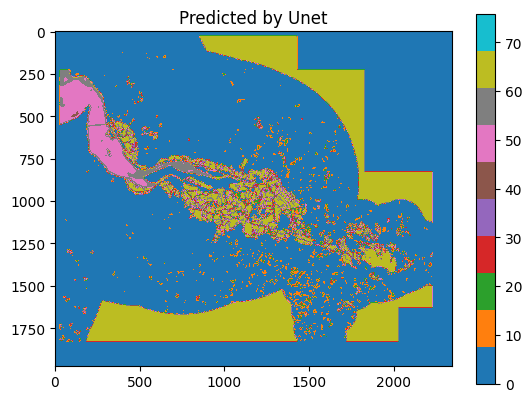

In [170]:
# Step6: Ploting the predicted image

  # Define the image location
img_src = "/predictions/SoftScore/prob_c11_r60_Cat_1.tif"
WorkingFolder = WorkingFolder
rast_img_file = (WorkingFolder + img_src)
  # Load the image
with rasterio.open(rast_img_file) as src:
  pred_img1 = src.read(1)

  plt.imshow(pred_img1, cmap="tab10")
  plt.title("Predicted by Unet")
  plt.colorbar()
  plt.show()



## Plotting Predicted Map based on Unet_Attention Model


In [154]:
# Step 1: Model Initialize
Unet_model = unet_att(in_channels=in_channels,
                  n_classes=n_classes).to(device)

# Step2: Selecting Optimization Function
optimizer = optim.Adam(Unet_model.parameters(), lr=initial_lr)

# Step3: Selecting Loss Function
criterion = BalancedTverskyFocalCELoss()

# Step4: Model evaluation
pixel_acc, mean_acc, mean_iou, fw_iou = do_accuracy_evaluation(Unet_model,
                                                               val_loader,
                                                               num_classes = 10)
print("Pixel Accuracy:", pixel_acc,"\n",
      "Mean Accuracy:", mean_acc, "\n",
      "Mean IoU:", mean_iou, "\n",
      "Frequency Weighted IoU:", fw_iou)

Pixel Accuracy: 0.3289495999695825 
 Mean Accuracy: 0.5 
 Mean IoU: 0.16447479998479125 
 Frequency Weighted IoU: 0.10820783932014835


<ipython-input-22-c6e09f19cada>:11: RuntimeWarning: invalid value encountered in divide
  Acc = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
<ipython-input-22-c6e09f19cada>:16: RuntimeWarning: invalid value encountered in divide
  MIoU = np.diag(self.confusion_matrix) / (
<ipython-input-22-c6e09f19cada>:26: RuntimeWarning: invalid value encountered in divide
  iu = np.diag(self.confusion_matrix) / (


In [155]:
# Step5: Making prediction
tile_count = len(pd.read_csv(os.path.join(src_dir, csv_name)))
for i in range(tile_count):
  pred_data = load_data_pred("inference", csv_name, patch_size, overlap, i)
  do_prediction(pred_data, model, overlap, device, save_dir)


Number of patches: 88
Patched from:
[[128, 128], [328, 128], [528, 128], [728, 128], [928, 128], [1128, 128], [1328, 128], [1528, 128], [1728, 128], [128, 328], [328, 328], [528, 328], [728, 328], [928, 328], [1128, 328], [1328, 328], [1528, 328], [1728, 328], [128, 528], [328, 528], [528, 528], [728, 528], [928, 528], [1128, 528], [1328, 528], [1528, 528], [1728, 528], [128, 728], [328, 728], [528, 728], [728, 728], [928, 728], [1128, 728], [1328, 728], [1528, 728], [1728, 728], [128, 928], [328, 928], [528, 928], [728, 928], [928, 928], [1128, 928], [1328, 928], [1528, 928], [1728, 928], [128, 1128], [328, 1128], [528, 1128], [728, 1128], [928, 1128], [1128, 1128], [1328, 1128], [1528, 1128], [1728, 1128], [128, 1328], [328, 1328], [528, 1328], [728, 1328], [928, 1328], [1128, 1328], [1328, 1328], [1528, 1328], [1728, 1328], [328, 1528], [528, 1528], [728, 1528], [928, 1528], [1128, 1528], [1328, 1528], [1528, 1528], [1728, 1528], [328, 1728], [528, 1728], [728, 1728], [928, 1728], [

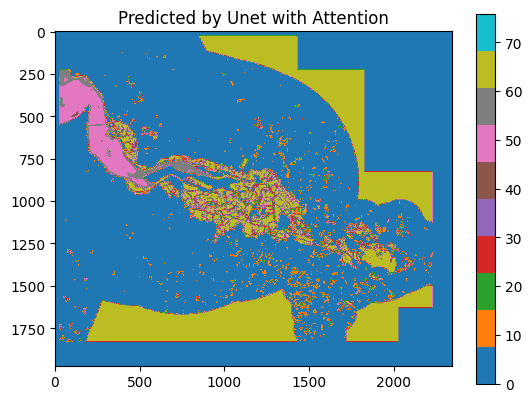

In [169]:
# Step6: Ploting the predicted image

  # Define the image location
img_src = "/predictions/SoftScore/prob_c11_r60_Cat_1.tif"
WorkingFolder = WorkingFolder
rast_img_file = (WorkingFolder + img_src)
  # Load the image
with rasterio.open(rast_img_file) as src:
  pred_img2 = src.read(1)

  plt.imshow(pred_img2, cmap="tab10")
  plt.title("Predicted by Unet with Attention")
  plt.colorbar()
  plt.show()


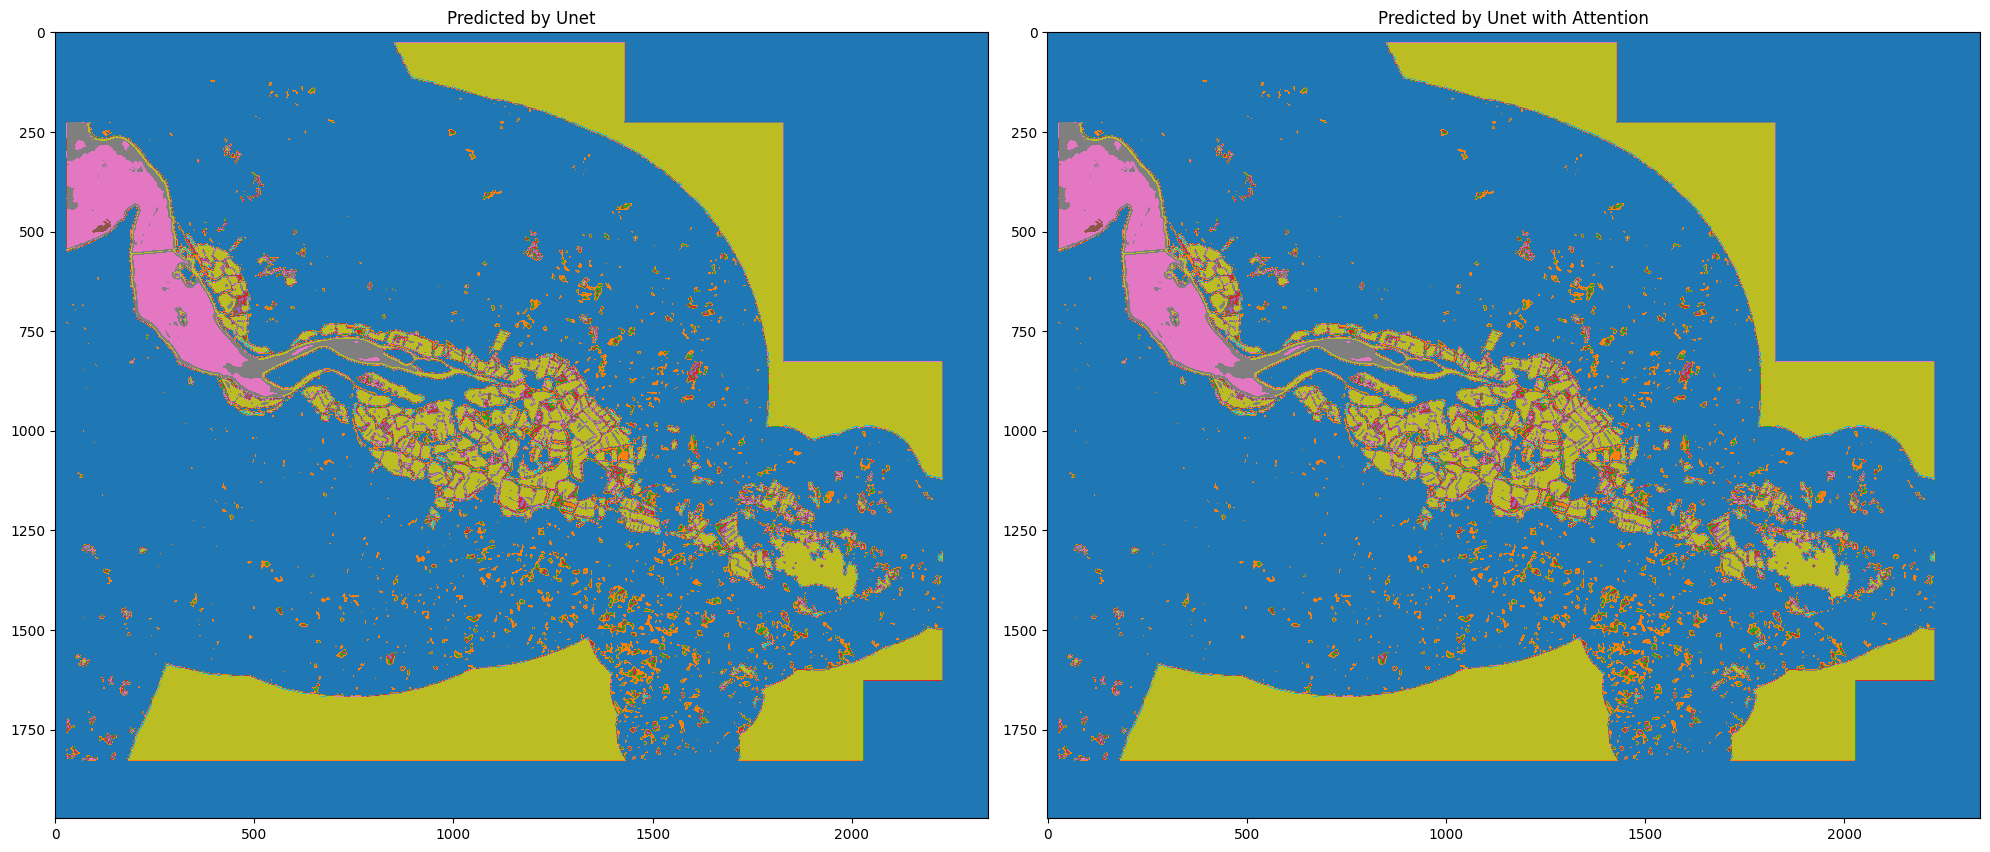

In [182]:
plt.figure(figsize=(20, 10))
# Create a subplot layout with two rows and one column
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# Plot the first image in the first subplot
ax1.imshow(pred_img1, cmap = "tab10")
ax1.set_title("Predicted by Unet")

# Plot the second image in the second subplot
ax2.imshow(pred_img2,  cmap = "tab10")
ax2.set_title("Predicted by Unet with Attention")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()